# Project Report (Group 93)
## Training a classification model to determine water potability based on measurable predictors



### Introduction

Potable water (water that is safe to drink) is a basic requirement for human life. Lack of access to potable water is an issue that continues to affect many regions globally. The United Nations Sustainable Development Goal 6 is accordingly: "Ensure availability and sustainable management of water and sanitation for all”. According to the most recent 2020 report from the World Health Organization (WHO), an estimated 26% of the global population (1.97 billion individuals) did not have access to safely managed drinking water services (1). Researching sufficiently fast, reliable, and cost-effective ways of evaluating the safety of drinking water is crucial to addressing this issue. In 2016, UNICEF called for the production of rapid-test kits for detecting the bacterium *Escherichia coli* (usually present in fecally contaminated water) (https://www.unicef.org/innovation/rapid-water-quality-testing). Apart from microbes, various other factors affect water potability. For example, trihalomethanes are a type of disinfection by-products produced during some water treatment processes, and have been demonstrated to be carcinogenic to humans (2).

In this project, we will utilize a synthetically generated dataset (https://www.kaggle.com/datasets/adityakadiwal/water-potability) containing over 3000 observations, each representing a sample of water. Each observation contains nine variables that affect water potability (pH, hardness, total dissolved solids, chloramines, sulfate, conductivity, organic carbon, trihalomethanes, and turbidity) as well as a score indicating whether or not the water is potable. Using this dataset, we aim to demonstrate how a classification model can be trained to accurately evaluate whether or not an unknown sample of water is potable based on measurable variables.

### Methods & Results

#### Exploratory Data Analysis

In [2]:
library(tidyverse)
library(digest)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
set.seed(2023)
options(repr.plot.width = 8, repr.plot.height = 7)
#1. READ DATA
url <- "https://raw.githubusercontent.com/Swapnil-Dubey/Dsci100_Group93_/main/data/water_potability.csv"
water_potability_raw <- read_csv(url) #unedited "raw" dataset

print(paste("Number of rows in the table: ",nrow(water_potability_raw))) #show number of observations in the raw dataset.
print(paste("Number of columns in the table: ",ncol(water_potability_raw))) #show number of variables in the raw dataset.

head(water_potability_raw)

Rows: 3276 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (10): ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Number of rows in the table:  3276"
[1] "Number of columns in the table:  10"


ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA,204.8905,20791.32,7.300212,368.5164,564.3087,10.379783,86.99097,2.963135,0
3.716080,129.4229,18630.06,6.635246,NA,592.8854,15.180013,56.32908,4.500656,0
8.099124,224.2363,19909.54,9.275884,NA,418.6062,16.868637,66.42009,3.055934,0
8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0


<center> (Figure 1: Original water potability dataset) </center>

<hr noshade>

Before we move on to the classification component, it is always required that we take a look at our data and understand the problem and the structure of the data and clean the data if necessary. 
    <br> </br>
    
Here you can notice that the predictive variable i.e <i>Potability</i> is of numeric type, however it only takes up the value 0 or 1 and hence we use `as.factor()` to convert it into a factor. <br>
Furthermore, we don't want our data to contain any `NA` values, and hence we will ignore those values using `na.omit()`

In [4]:
#2. CLEAN DATA AND REMOVE NA ROWS
water_potability_clean <- water_potability_raw |>
    rename(hardness = Hardness, solids = Solids, chloramines = Chloramines, sulfate = Sulfate, conductivity = Conductivity, organic_carbon = Organic_carbon, trihalomethanes = Trihalomethanes, turbidity = Turbidity, potability = Potability) |>
    mutate(potability = as_factor(potability)) |>
    na.omit()

print(paste("Number of rows in the table: ",nrow(water_potability_clean))) #number of observations in the cleaned dataset (NA removed)
print(paste("Number of columns in the table: ",ncol(water_potability_clean))) #number of variables in the cleaned dataset (NA removed)

head(water_potability_clean)

[1] "Number of rows in the table:  2011"
[1] "Number of columns in the table:  10"


ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.558279,31.99799,4.075075,0
5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0
10.223862,248.0717,28749.72,7.513408,393.6634,283.6516,13.789695,84.60356,2.672989,0
8.635849,203.3615,13672.09,4.563009,303.3098,474.6076,12.363817,62.79831,4.401425,0
11.180284,227.2315,25484.51,9.077200,404.0416,563.8855,17.927806,71.97660,4.370562,0


<center> (Figure 2: Clean water potability dataset) </center>

<hr noshade>

The next step is to divide the data into training and testing dataset after selecting a predictive question to answer and wrangling the data. We split it in the ratio 3:1 (training: 75% , testing: 25%) 
    
The `initial_split` function from `tidymodels` library splits the data for us.
    

In [5]:
set.seed(2023)
#3. CREATE TRAINING DATA and TESTING DATA
water_split <- water_potability_clean |> #split the data 0.75/0.25
    initial_split(prop = 0.75, strata = potability) 


water_train <- training(water_split)  #set the 0.75 split as the training data
water_test <- testing(water_split) #set the 0.25 split as the testing data

head(water_train)

ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
9.092223,181.1015,17978.99,6.546600,310.1357,398.4108,11.55828,31.99799,4.075075,0
8.635849,203.3615,13672.09,4.563009,303.3098,474.6076,12.36382,62.79831,4.401425,0
11.180284,227.2315,25484.51,9.077200,404.0416,563.8855,17.92781,71.97660,4.370562,0
7.360640,165.5208,32452.61,7.550701,326.6244,425.3834,15.58681,78.74002,3.662292,0
7.119824,156.7050,18730.81,3.606036,282.3441,347.7150,15.92954,79.50078,3.445756,0
6.347272,186.7329,41065.23,9.629596,364.4877,516.7433,11.53978,75.07162,4.376348,0


<center> (Figure 3: Training water potability dataset) </center>

<hr noshade> 

Here we are trying to analyze the data i.e finding the mean of all the predictor variables for each group (potable and non-potable) <br>

We use `summarize()` and `group_by` to find the means of all the predictor variables and count the number of observations for each group.
   

In [6]:
#4. SUMMARIZE DATA IN A TABLE
water_train_means <- water_train |> #find means for all predictors grouped by potability
    group_by(potability) |>
    summarize(across(ph:turbidity, mean, na.rm=TRUE))

water_train_nrows <- water_train |> #count number of observations in the two groups
    group_by(potability) |>
    summarize(n = n())

water_train_summary <- water_train_means |> #merge grouped n dataframe with grouped means dataframe
    merge(water_train_nrows)

water_train_summary

potability,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,7.041711,196.2666,21591.49,7.102538,334.1355,427.0587,14.43886,65.94446,3.969137,900
1,7.123942,196.7239,22352.82,7.195704,331.1790,422.0726,14.38643,66.82991,3.984172,608


In [7]:
water_train %>%
    group_by(potability) %>%
    summarize(percentage = n()/nrow(water_train))

potability,percentage
<fct>,<dbl>
0,0.596817
1,0.403183


<center> (Figure 4: Summarizing our water potability dataset to <br> find the mean of all the variables for each potability value) </center>

<hr noshade>

Let us get a summary of our data using the `summary()` function. This gives us the minimum, maximum, mean, median and quantile values. <br>
Quantile value determines what a fraction of the data looks like. For example the 1st quantile value for ph tells us that 25% of the data lies below 6.0767. <br>
<i>Note:</i> We do not remove the outliers from our data because they hold a meaning. For example a value as low as 320.9 in solids isn't considered as an outlier because it corresponds to less number of minerals present in that particular sample of water.

In [8]:
summary_water_potability <- summary(water_train)
summary_water_potability

       ph             hardness          solids         chloramines    
 Min.   : 0.2275   Min.   : 73.49   Min.   :  320.9   Min.   : 1.391  
 1st Qu.: 6.0767   1st Qu.:177.55   1st Qu.:15585.0   1st Qu.: 6.164  
 Median : 7.0422   Median :198.08   Median :20844.8   Median : 7.145  
 Mean   : 7.0749   Mean   :196.45   Mean   :21898.5   Mean   : 7.140  
 3rd Qu.: 8.0515   3rd Qu.:216.66   3rd Qu.:27165.8   3rd Qu.: 8.144  
 Max.   :14.0000   Max.   :317.34   Max.   :56488.7   Max.   :13.127  
    sulfate       conductivity   organic_carbon  trihalomethanes  
 Min.   :129.0   Min.   :201.6   Min.   : 2.20   Min.   :  8.577  
 1st Qu.:306.8   1st Qu.:363.9   1st Qu.:12.17   1st Qu.: 55.691  
 Median :332.5   Median :422.2   Median :14.32   Median : 66.672  
 Mean   :332.9   Mean   :425.0   Mean   :14.42   Mean   : 66.301  
 3rd Qu.:360.3   3rd Qu.:481.0   3rd Qu.:16.84   3rd Qu.: 77.137  
 Max.   :481.0   Max.   :753.3   Max.   :27.01   Max.   :124.000  
   turbidity     potability
 Min. 

<center> (Figure 5: Summary of our water potability dataset) </center>

<hr noshade>

We now want to check for the number of predictor variables necessary for our model. For that purpose we find the correlation between each predictor variables. <br>
The `ggpairs()` function from `GGally` library helps us do so by visualizing the correlation between them. <br>
Here we find that none of the predictor variables are strongly related with each other and hence we decide to take all the variables into consideration when building our model. <br>
<i>Note:</i> Weak correlation corresponds to a value closer to 0 while a strong correlation has the correlation value closer to 1 or -1.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



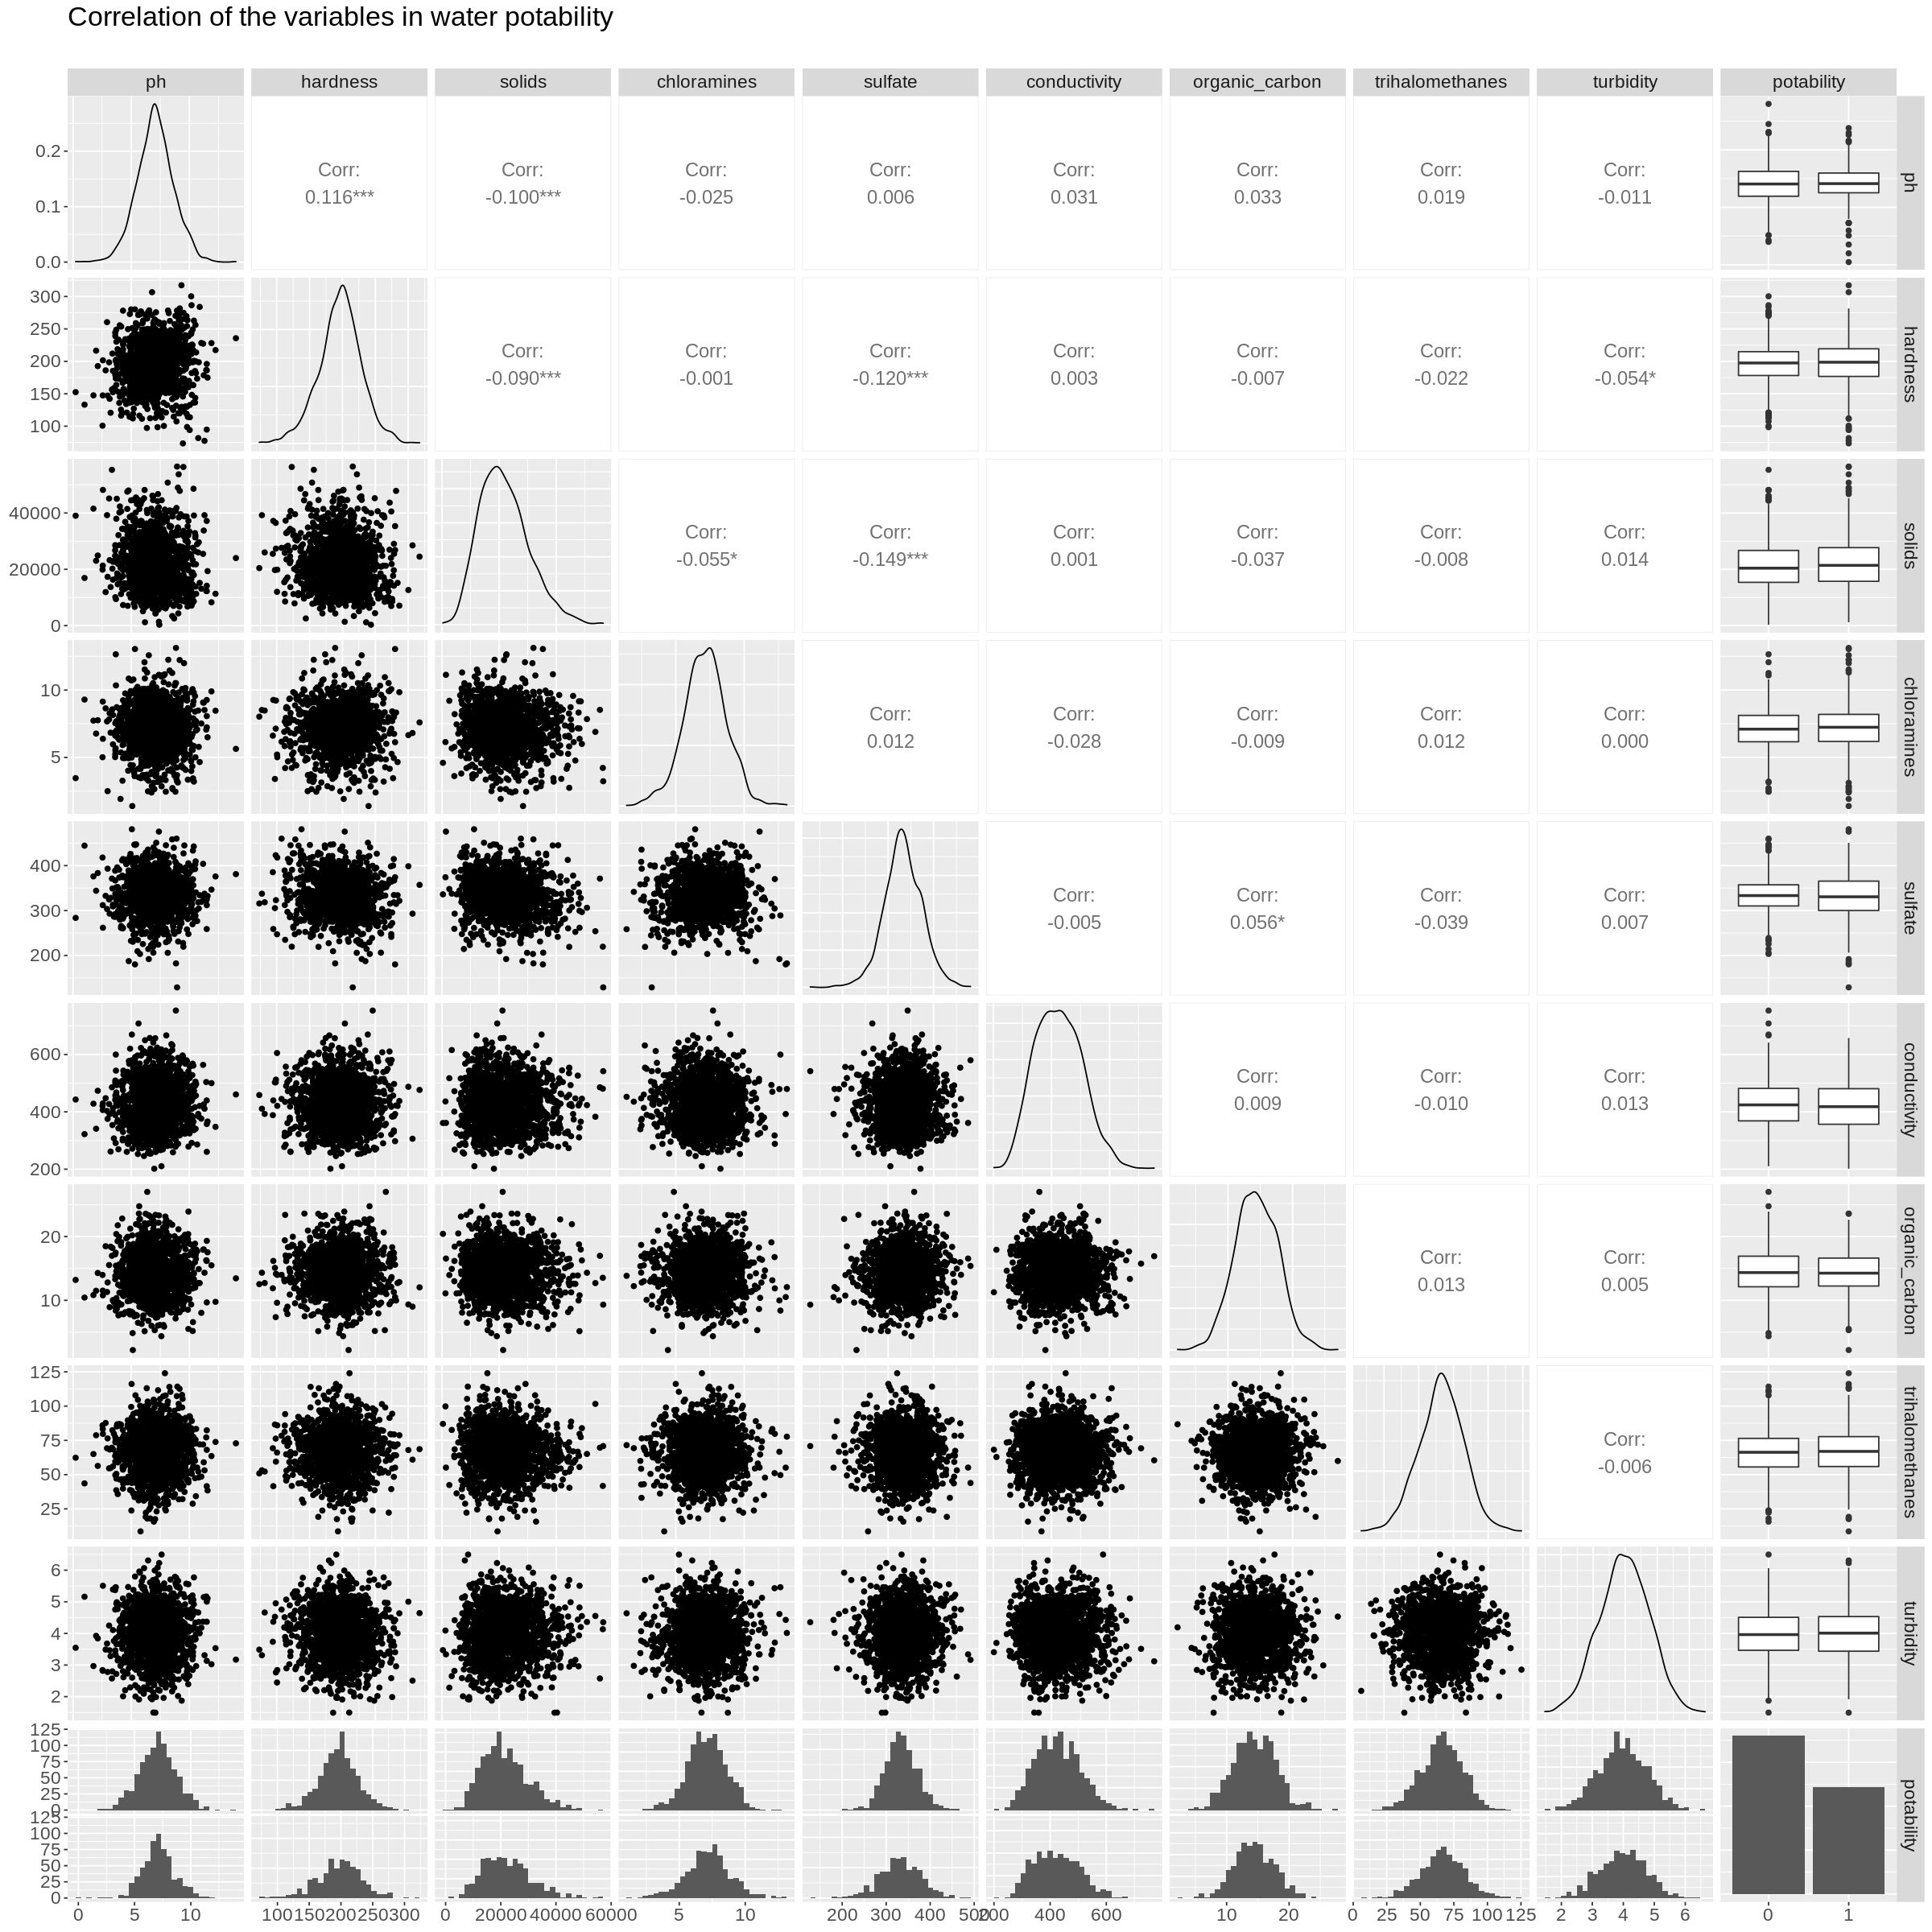

In [9]:
options(repr.plot.width = 20, repr.plot.height = 20)

water_eda <- water_train |>
ggpairs(title = "Correlation of the variables in water potability \n",upper = list(continuous = wrap("cor", size = 5))) + theme(text = element_text(size = 17))

water_eda

<center> (Figure 6: Correlation of the variables in water potability) </center>

<hr noshade>

Whenever using K-nearest neighbor classification scaling matters (size and range of each variable). This is because any variables with a large scale will have a much larger effect than variables with a small scale because the classifier predicts classes by identifying observations closest to them. <br>
We normally scale the data when creating the knn-model recipe using `step_scale()` and `step_center()`.

Here, we scale all of the predictors as a percentage of the range of each predictor. This is done according to (Xi - Xmin)/(Xmax - Xmin).

In [10]:
#5. SCALE TRAINING DATA (0 to 1)
min_table <- water_train |> #min value of all predictors
    select(-potability) |>
    map_df(min)

max_table <- water_train |> #max value of all predictors
    select(-potability) |>
    map_df(max)

diff_table <- max_table - min_table #max - min for all predictors

water_train_scaled <- water_train |> #scale all predictors X (0 to 1) according to (Xi - Xmin)/(Xmax - Xmin)
    select(-potability) |>
    mutate(ph = (ph - min_table$ph) / diff_table$ph, 
           hardness = (hardness - min_table$hardness) / diff_table$hardness,
           solids = (solids - min_table$solids) / diff_table$solids, 
           chloramines = (chloramines - min_table$chloramines) / diff_table$chloramines,
           sulfate = (sulfate - min_table$sulfate) / diff_table$sulfate, 
           conductivity = (conductivity - min_table$conductivity) / diff_table$conductivity,
           organic_carbon = (organic_carbon - min_table$organic_carbon) / diff_table$organic_carbon, 
           trihalomethanes = (trihalomethanes - min_table$trihalomethanes) / diff_table$trihalomethanes,
           turbidity = (turbidity - min_table$turbidity) / diff_table$turbidity) |>
    bind_cols(potability = water_train$potability)

Next, we will calculate the means for all predictors in both groups (potable and not potable).

In [11]:
water_train_scaled_means_potable <- water_train_scaled |>
    filter(potability == "1") |>
    select(-potability) |>
    map_df(mean, na.rm = TRUE)
    

water_train_scaled_means_not_potable <- water_train_scaled |>
    filter(potability == "0") |>
    select(-potability) |>
    map_df(mean, na.rm = TRUE)
    

potability_tibble <- tibble(potability = 0:1) |>
    mutate(potability = as_factor(potability))

water_train_scaled_means <- bind_rows(water_train_scaled_means_not_potable, water_train_scaled_means_potable) |>
    bind_cols(potability_tibble)

water_train_scaled_means

ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.4947694,0.5034917,0.3786970,0.4866738,0.5827206,0.4086090,0.4933688,0.4970193,0.4951344,0
0.5007401,0.5053669,0.3922516,0.4946122,0.5743222,0.3995717,0.4912555,0.5046906,0.4981399,1


<center> (Figure 7: Scaled means of all predictors according to potability) </center>

<hr noshade>

We visualize the the means of each predictor variables grouped by each of the potability type in order to compare and analyze the trend <br>
Here we make use of the `ggplot()` function from the `ggplot2` package which has already been loaded by the `tidyverse` package. 

The percentage-scaled means of each predictor is plotted below in a bar graph, separated by potability. Observe that there is virtually no difference in the means of each predictor between the potable and non-potable groups. This indicates that the data set was generated randomly and will make generating an accurate classification model quite difficult.

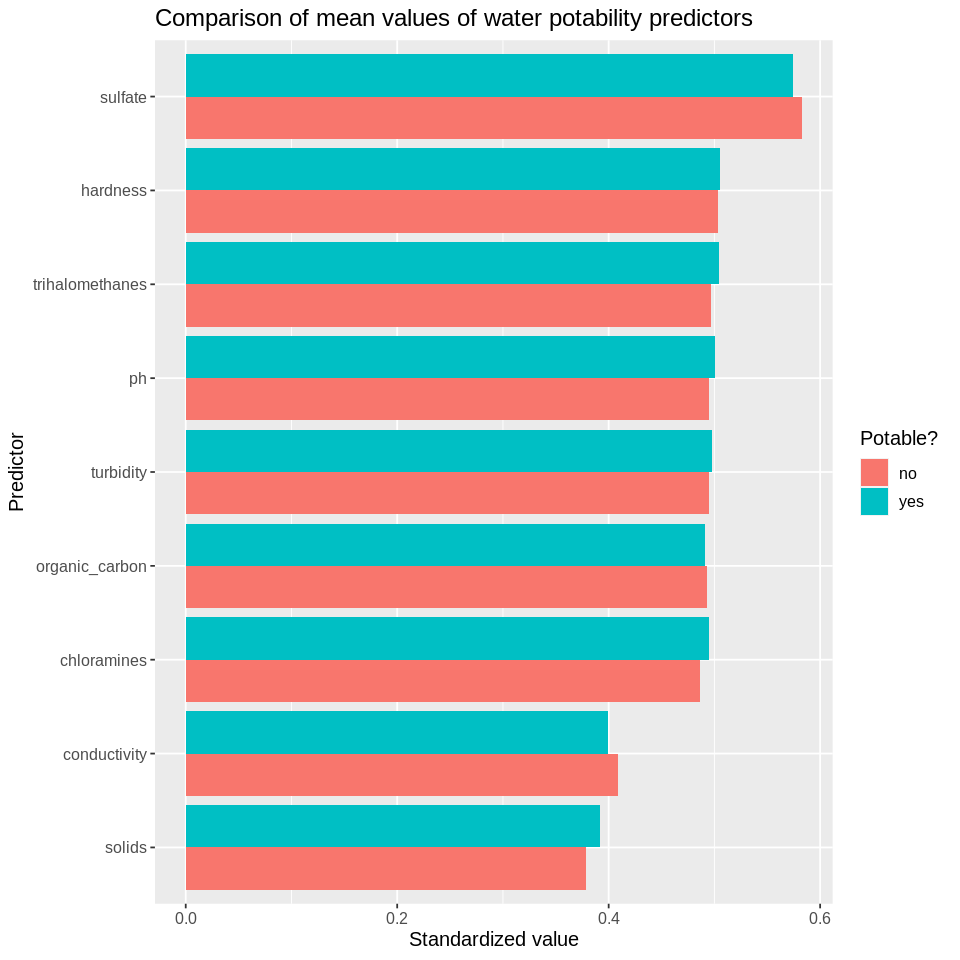

In [12]:
#6. PLOT SCALED TRAINING DATA (0-1) IN A BARPLOT SHOWING MEANS OF EACH PREDICTOR
options(repr.plot.width = 8, repr.plot.height = 8)

water_train_scaled_longer <- water_train_scaled_means |> #pivot longer, generating columns "predictor" and "value"
    pivot_longer(c(ph, hardness, solids, chloramines, sulfate, conductivity, organic_carbon, trihalomethanes, turbidity), names_to = "predictor")

water_train_barplot <- water_train_scaled_longer |> #barplot showing the scaled (0 to 1) means of each predictor grouped by potability
    mutate(potability = fct_recode(potability, "no" = "0", "yes" = "1")) |>
    ggplot(aes(y = reorder(predictor, value), x = value, fill = potability)) + 
    geom_col(position = 'dodge') + 
    xlab("Standardized value") +
    ylab("Predictor") +
    labs(fill = "Potable?") +
    ggtitle("Comparison of mean values of water potability predictors") +
    theme(text = element_text(size = 12))

water_train_barplot

<center> (Figure 8: Comparison of mean values of water potability predictors) </center>

<hr noshade>

To demonstrate this, below is a scatterplot comparing the distributions of two predictors (in this case, pH and hardness). We can observe that the distribution is quite random and there is significant overlap between the potable and non-potable data points. While it is not shown here, the same is true using any combination of predictors.

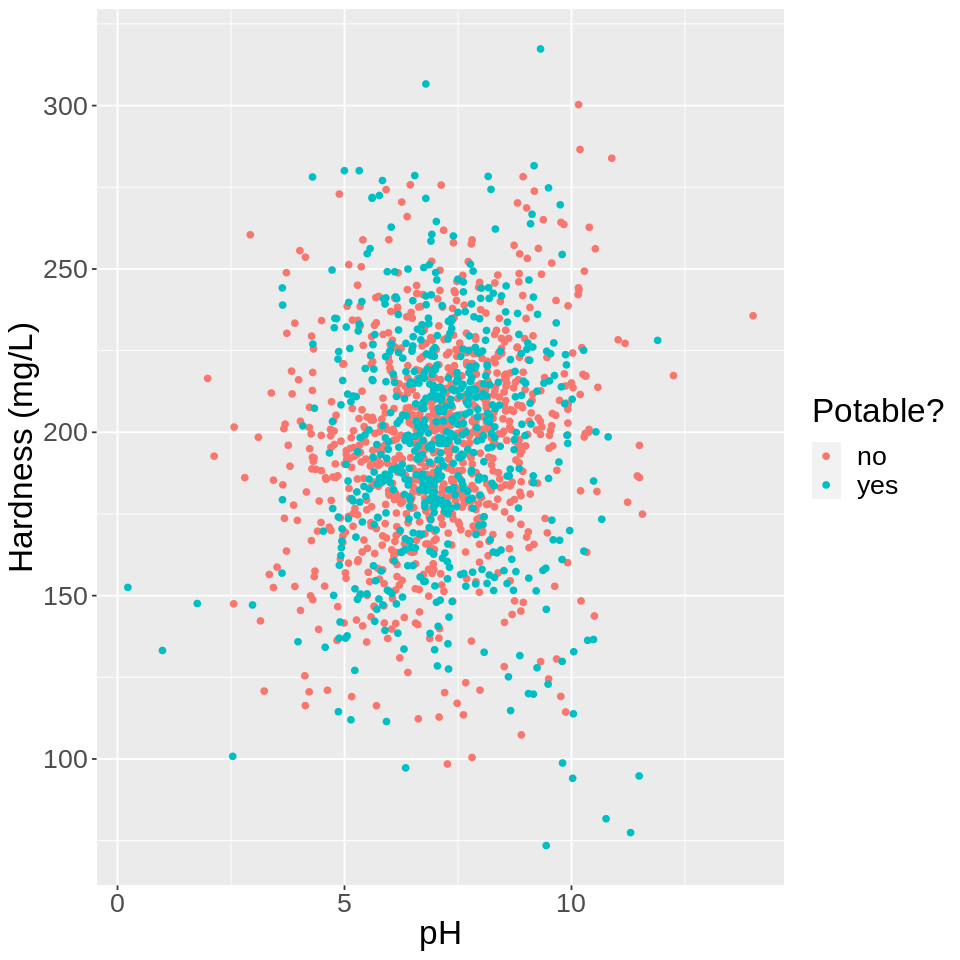

In [13]:
# #7. SCALE TRAINING DATA USING SCALE()
# water_train_scaled_2 <- water_train |> #scale all predictors using the scale() function
#     select(-potability) |>
#     scale(center = TRUE, scale = TRUE) |>
#     bind_cols(potability = water_train$potability)

#8. PLOT TRAINING DATA IN A SCATTERPLOT COMPARING THE DISTRIBUTION ACCORDING TO TWO SELECTED PREDICTORS
water_train_scatterplot <- water_train |> #scatterplot comparing two predictors--in this case, pH and hardness, standardized
    mutate(potability = fct_recode(potability, "no" = "0", "yes" = "1")) |>
    ggplot(aes(x = ph, y = hardness, color = potability)) +
    geom_point() +
    labs(x = "pH", y = "Hardness (mg/L)", color = "Potable?") +
    theme(text = element_text(size = 20))

water_train_scatterplot

<center> (Figure 9: Distribution of mean values of water potability predictors) </center>

#### Generating, training, and testing the classification model

From the exploratory data analysis, we made the following observations:
- This synthetically generated data set was randomly generated without adherence to bona fide thresholds that determine water potability (even in accordance with the description provided by the author of the data set). A clearly demonstrable example is shown immediately above in Figure 9 above. Note that observations representing potable water (in blue) are present all across the pH spectrum, even at highly acidic (pH < 5) or highly basic (pH > 10) conditions. The same pattern can be observed looking at the other predictors (not shown).
- One consequence of randomly generated data in this manner is that the predictors have low correlation with one another. We will therefore proceed with the classification using all predictors. It is recommended that when using real data (and not synthetically generated data) to check for correlation between the predictors (multicollinearity).
- Another consequence is that the model generated in the following data analysis will have low accuracy and should not be used for water potability classification in the real world--only as a demonstration.

Next, we will proceed to generate, train, and test the classification model. 

First, we will generate the model for v-fold cross-validation and the recipe to classify potability based on all predictors. This is done using the `vfold_cv()` function from the `tidymodels` library. This process, known as cross-validation, divides the data set into ten folds and validates each of the folds against the others in sequence. This allows us to determine the best k-value by evaluating the accuracy of the classifier multiple times.

In [14]:
set.seed(2023)

water_vfold <- vfold_cv(water_train, v = 10, strata = potability)

water_recipe <- recipe(potability ~ ., data = water_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

<hr noshade>

Next, we will tune our K-nearest neighbors specification to determine the K-value which will give us the highest accuracy. Here we generate a K-nearest neighbors model using the `nearest_neighbor()` function, set the engine to `kknn` (K-nearest neighbors), and the mode to `classification`. Then, using the `workflow()` function, we combine the recipe and model to tune our classifier.

In [15]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_results <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = water_vfold, grid = 10) |>
    collect_metrics()

<hr noshade>

By filtering the results of our workflow by the "accuracy" metric and ordering it by descending accuracy, we are presented with the K-value with the highest accuracy at the top of the table.

In [16]:
accuracies <- knn_results |>
  filter(.metric == "accuracy") |>
  arrange(desc(mean))

accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.6332892,10,0.014652095,Preprocessor1_Model7
13,accuracy,binary,0.6319868,10,0.012031164,Preprocessor1_Model8
14,accuracy,binary,0.6319868,10,0.012031164,Preprocessor1_Model9
9,accuracy,binary,0.6319514,10,0.016662969,Preprocessor1_Model5
10,accuracy,binary,0.6319514,10,0.016662969,Preprocessor1_Model6
8,accuracy,binary,0.6173731,10,0.014508561,Preprocessor1_Model4
3,accuracy,binary,0.6147064,10,0.006599658,Preprocessor1_Model2
1,accuracy,binary,0.6114393,10,0.007923062,Preprocessor1_Model1
5,accuracy,binary,0.6087417,10,0.014315208,Preprocessor1_Model3


<center>(Figure 10: Table of accuracies at each K-value)</center>

<hr noshade>

We can also visualize the K-value selection process in the form of a line graph with accuracy on the y-axis vs. k-value on the x-axis. Note that accuracy is at its maximum when k = 11 (given the high randomness of this data set, this value will vary greatly if the random seed is changed compared to a real-world data set).

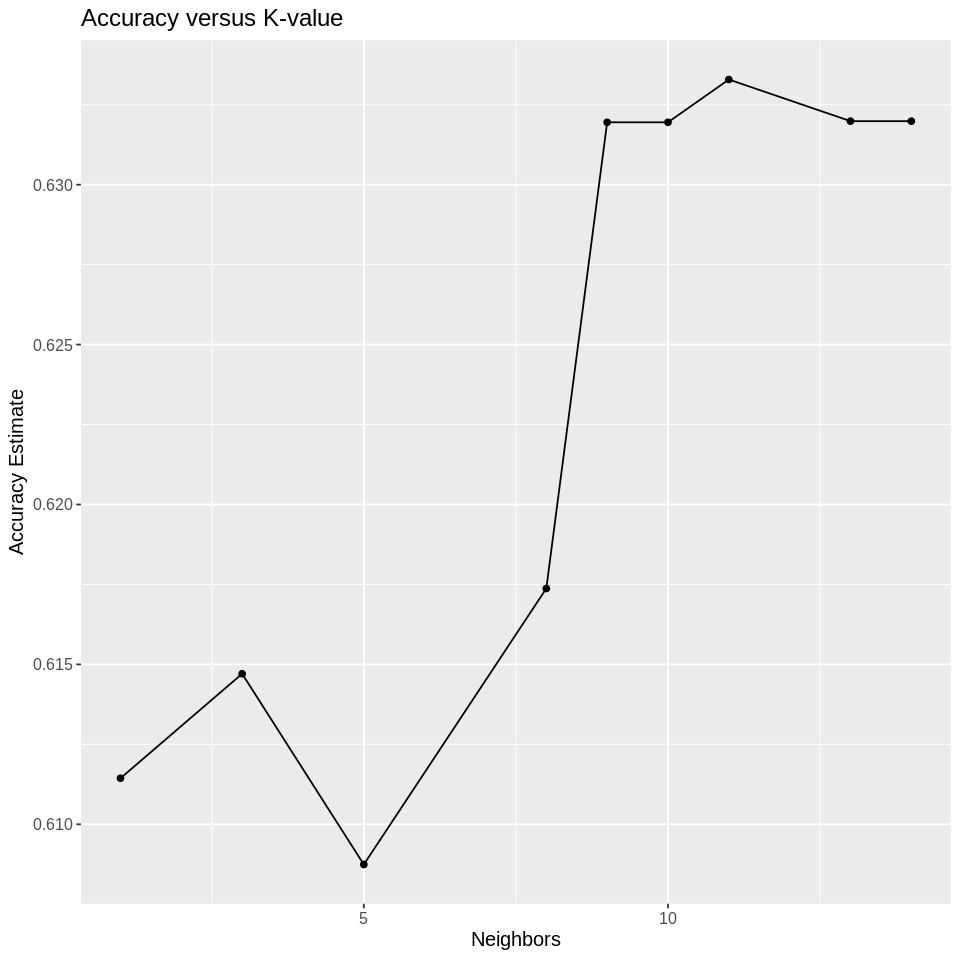

In [17]:
options(repr.plot.width = 8, repr.plot.height = 8)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  ggtitle("Accuracy versus K-value") +
  theme(text = element_text(size = 12))

accuracy_vs_k

<center>(Figure 11: Accuracy versus K-value)</center>

<hr noshade>

We will then generate a new K-nearest neighbors model using K = 11.

In [18]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

<hr noshade>

Then, we can put the recipe generated earlier together with our new model in the `workflow()` function and fit it to our training data set. Our classification model is now trained and complete!

In [19]:
water_fit <- workflow() |>
    add_recipe(water_recipe) |>
    add_model(knn_best_spec) |>
    fit(data = water_train)

<hr noshade>

Now, we can use test the model on the testing data set to determine how accurate it is:

In [20]:
water_predictions <- predict(water_fit, water_test) |>
    bind_cols(water_test)

head(water_predictions)

.pred_class,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,8.316766,214.3734,22018.42,8.059332,356.8861,363.2665,18.436524,100.34167,4.628771,0
0,5.584087,188.3133,28748.69,7.544869,326.6784,280.4679,8.399735,54.91786,2.559708,0
0,10.223862,248.0717,28749.72,7.513408,393.6634,283.6516,13.789695,84.60356,2.672989,0
0,6.514415,198.7674,21218.70,8.670937,323.5963,413.2905,14.900000,79.84784,5.200885,0
0,3.445062,207.9263,33424.77,8.782147,384.0070,441.7859,13.805902,30.28460,4.184397,0
1,10.433291,117.7912,22326.89,8.161505,307.7075,412.9868,12.890709,65.73348,5.057311,0


<center>(Figure 12: Table of predictions of the testing data set.)</center>

<hr noshade>

Next, we can retrieve the accuracy of our predictions.

In [21]:
water_acc <- water_predictions |>
    metrics(truth = potability, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1) |>
    pull()

water_acc

[1] 0.638171

<hr noshade>

63.82% of the time, the classification model correctly predicted whether the water was potable or not. This is quite a low value but to be expected given the randomness of this data. Most of the time, the values of the predictors beared no meaning on whether or not the water was potable. However, if the data set had been better generated, then the accuracy would be much higher.

Next, we can generate a confusion matrix to show how many false positives (incorrectly guessed that the water was potable when it was not) and false negatives (incorrectly guessed that the water was not potable when it was) there were.

In [22]:
water_cm <- water_predictions |>
    conf_mat(truth = potability, estimate = .pred_class)

water_cm

          Truth
Prediction   0   1
         0 257 139
         1  43  64

<center>(Figure 13: Confusion matrix for water potability predictions)</center>

<hr noshade>

There were 257 true negatives, 139 false negatives, 43 true positives, and 64 false positives. Overall, these do not represent great numbers, and a classification model returning such values would not suffice for evaluating water potability. This can be attributed to either a poor classification model, or (more likely in this case) poor data quality.

### Discussion

TO DO

### References

(1) World Health Organization; United Nations Children’s Fund (UNICEF); World Bank. State of the World’s Drinking Water: An Urgent Call to Action to Accelerate Progress on Ensuring Safe Drinking Water for All; World Health Organization: Geneva, 2022.

(2) Srivastav, A. L.; Patel, N.; Chaudhary, V. K. Disinfection By-Products in Drinking Water: Occurrence, Toxicity and Abatement. Environmental Pollution 2020, 267, 115474. https://doi.org/10.1016/j.envpol.2020.115474.

(3) Timbers, T.-A.; Campbell, T.; Lee, M. Data Science: An Introduction, First edition.; Statistics; CRC Press: Boca Raton, 2022.